https://huggingface.co/blog/patchtsmixer

# Module Import

In [35]:
# Standard
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import random

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd
import torch

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

# Set Seed

In [36]:
from transformers import set_seed

set_seed(42)

# Dataset Load and ready

- dataset_path: 로컬 .csv 파일의 경로 또는 관심 있는 데이터의 csv 파일에 대한 웹 주소입니다. 데이터는 판다로 로드되므로 pd.read_csv에서 지원하는 것은 무엇이든 지원됩니다: (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
- timestamp_column: 타임스탬프 정보가 포함된 열 이름, 해당 열이 없는 경우 None을 사용합니다.
- id_columns: 서로 다른 시계열의 ID를 지정하는 열 이름 목록입니다. ID 열이 없는 경우 []를 사용합니다.
- forecast_columns: 모델링할 열 목록입니다.
- context_length: 모델에 입력으로 사용되는 과거 데이터의 양입니다. 입력 데이터 프레임에서 context_length와 같은 길이를 가진 입력 시계열 데이터의 윈도우가 추출됩니다. 다중 시계열 데이터 집합의 경우, 컨텍스트 윈도우는 단일 시계열(즉, 단일 ID) 내에 포함되도록 만들어집니다.
- forecast_horizon: 앞으로 예측할 타임스탬프의 수입니다.
- train_start_index, train_end_index: 학습 데이터를 나타내는 로드된 데이터의 시작 및 종료 인덱스입니다.
- valid_start_index, valid_end_index: 유효성 검사 데이터를 나타내는 로드된 데이터의 시작 및 종료 인덱스입니다.
- test_start_index, test_end_index: 로드된 데이터에서 테스트 데이터를 나타내는 시작 및 종료 인덱스입니다.
- num_workers: PyTorch 데이터로더의 CPU 워커 수입니다.
- batch_size: 배치 크기. 데이터는 먼저 Pandas 데이터 프레임에 로드되고 훈련, 검증 및 테스트 부분으로 나뉩니다. 그런 다음 Pandas 데이터 프레임은 학습에 필요한 적절한 PyTorch 데이터 세트로 변환됩니다.

In [37]:
from glob import glob
# Download ECL data from https://github.com/zhouhaoyi/Informer2020
dataset_path = glob(os.path.join(os.path.abspath(os.path.pardir), "data", "raw", "*.parquet"))
timestamp_column = "STCK_CNTG_HOUR"
id_columns = []

context_length = 512 # 512
forecast_horizon = 96 # 96
num_workers = 16  # Reduce this if you have low number of CPU cores
batch_size = 512  # Adjust according to GPU memory

In [38]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore, boxcox
scaler = StandardScaler()

data = pd.read_parquet(
    dataset_path[11],
    # parse_dates=[timestamp_column],
)
######################
from gluonts.time_feature import get_lags_for_frequency, time_features_from_frequency_str

data["AMOUNT"] = data["STCK_PRPR"] * data["CNTG_VOL"]
data["STCK_PRPR"] = scaler.fit_transform(data["STCK_PRPR"].values.reshape(-1,1))

freq = "1s"
lags_sequence = get_lags_for_frequency(freq)
time_features = time_features_from_frequency_str(freq)

timestamp_as_index = pd.DatetimeIndex(data[timestamp_column])
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
data = pd.concat([data, pd.DataFrame(dict(additional_features))], axis=1)
data[["AMOUNT", "CNTG_VOL"]] = scaler.fit_transform(data[["AMOUNT", "CNTG_VOL"]])
######################

forecast_columns = list(data.columns.difference([timestamp_column, "MKSC_SHRN_ISCD", "target", "day_of_year", "STCK_PRPR"]))
forecast_columns

['AMOUNT',
 'CCLD_DVSN',
 'CNTG_VOL',
 'day_of_month',
 'day_of_week',
 'hour_of_day',
 'minute_of_hour',
 'second_of_minute']

In [53]:
pd.read_parquet(
    dataset_path[11])

,MKSC_SHRN_ISCD,STCK_CNTG_HOUR,STCK_PRPR,CNTG_VOL,CCLD_DVSN
0,FSN,2021-11-10 09:00:18,7000.0,136862.0,1.0
1,FSN,2021-11-10 09:00:18,6990.0,704.0,5.0
2,FSN,2021-11-10 09:00:19,6980.0,305.0,5.0
3,FSN,2021-11-10 09:00:19,6990.0,895.0,5.0
4,FSN,2021-11-10 09:00:19,6990.0,1200.0,5.0
...,...,...,...,...,...
1471522,FSN,2022-02-28 15:45:03,7650.0,1.0,1.0
1471523,FSN,2022-02-28 15:45:40,7650.0,100.0,1.0
1471524,FSN,2022-02-28 15:49:05,7650.0,96.0,1.0
1471525,FSN,2022-02-28 15:50:09,7650.0,5.0,5.0


In [52]:
data[forecast_columns]

,AMOUNT,CCLD_DVSN,CNTG_VOL,day_of_month,day_of_week,hour_of_day,minute_of_hour,second_of_minute
0,64.584900,1.0,99.868797,-0.2,-0.166667,-0.108696,-0.500000,-0.194915
1,0.182426,5.0,0.357328,-0.2,-0.166667,-0.108696,-0.500000,-0.194915
2,-0.006236,5.0,0.065718,-0.2,-0.166667,-0.108696,-0.500000,-0.177966
3,0.272639,5.0,0.496921,-0.2,-0.166667,-0.108696,-0.500000,-0.177966
4,0.416696,5.0,0.719831,-0.2,-0.166667,-0.108696,-0.500000,-0.177966
...,...,...,...,...,...,...,...,...
1471522,-0.149570,1.0,-0.156462,0.4,-0.500000,0.152174,0.262712,-0.449153
1471523,-0.098395,1.0,-0.084107,0.4,-0.500000,0.152174,0.262712,0.177966
1471524,-0.100463,1.0,-0.087031,0.4,-0.500000,0.152174,0.330508,-0.415254
1471525,-0.147502,5.0,-0.153538,0.4,-0.500000,0.152174,0.347458,-0.347458


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>AMOUNT</th>
      <th>CCLD_DVSN</th>
      <th>CNTG_VOL</th>
      <th>day_of_month</th>
      <th>day_of_week</th>
      <th>hour_of_day</th>
      <th>minute_of_hour</th>
      <th>second_of_minute</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>64.584900</td>
      <td>1.0</td>
      <td>99.868797</td>
      <td>-0.2</td>
      <td>-0.166667</td>
      <td>-0.108696</td>
      <td>-0.500000</td>
      <td>-0.194915</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.182426</td>
      <td>5.0</td>
      <td>0.357328</td>
      <td>-0.2</td>
      <td>-0.166667</td>
      <td>-0.108696</td>
      <td>-0.500000</td>
      <td>-0.194915</td>
    </tr>
    <tr>
      <th>2</th>
      <td>-0.006236</td>
      <td>5.0</td>
      <td>0.065718</td>
      <td>-0.2</td>
      <td>-0.166667</td>
      <td>-0.108696</td>
      <td>-0.500000</td>
      <td>-0.177966</td>
    </tr>
    <tr>
      <th>3</th>
      <td>0.272639</td>
      <td>5.0</td>
      <td>0.496921</td>
      <td>-0.2</td>
      <td>-0.166667</td>
      <td>-0.108696</td>
      <td>-0.500000</td>
      <td>-0.177966</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0.416696</td>
      <td>5.0</td>
      <td>0.719831</td>
      <td>-0.2</td>
      <td>-0.166667</td>
      <td>-0.108696</td>
      <td>-0.500000</td>
      <td>-0.177966</td>
    </tr>
    <tr>
      <th>...</th>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
    </tr>
    <tr>
      <th>1471522</th>
      <td>-0.149570</td>
      <td>1.0</td>
      <td>-0.156462</td>
      <td>0.4</td>
      <td>-0.500000</td>
      <td>0.152174</td>
      <td>0.262712</td>
      <td>-0.449153</td>
    </tr>
    <tr>
      <th>1471523</th>
      <td>-0.098395</td>
      <td>1.0</td>
      <td>-0.084107</td>
      <td>0.4</td>
      <td>-0.500000</td>
      <td>0.152174</td>
      <td>0.262712</td>
      <td>0.177966</td>
    </tr>
    <tr>
      <th>1471524</th>
      <td>-0.100463</td>
      <td>1.0</td>
      <td>-0.087031</td>
      <td>0.4</td>
      <td>-0.500000</td>
      <td>0.152174</td>
      <td>0.330508</td>
      <td>-0.415254</td>
    </tr>
    <tr>
      <th>1471525</th>
      <td>-0.147502</td>
      <td>5.0</td>
      <td>-0.153538</td>
      <td>0.4</td>
      <td>-0.500000</td>
      <td>0.152174</td>
      <td>0.347458</td>
      <td>-0.347458</td>
    </tr>
    <tr>
      <th>1471526</th>
      <td>-0.140782</td>
      <td>1.0</td>
      <td>-0.144037</td>
      <td>0.4</td>
      <td>-0.500000</td>
      <td>0.152174</td>
      <td>0.500000</td>
      <td>-0.364407</td>
    </tr>
  </tbody>
</table>
<p>1471527 rows × 8 columns</p>
</div>

<Axes: >

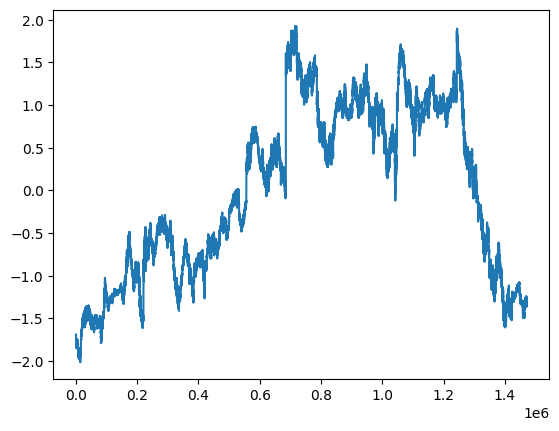

In [39]:
data["STCK_PRPR"].plot()

In [40]:
# get split
num_train = int(len(data) * 0.7)
num_test = int(len(data) * 0.2)
num_valid = len(data) - num_train - num_test
border1s = [
    0,
    num_train - context_length,
    len(data) - num_test - context_length,
]
border2s = [num_train, num_train + num_valid, len(data)]

In [41]:
print("Border 1s :",border1s)
print("Border 2s :",border2s)

Border 1s : [0, 1029556, 1176710]
Border 2s : [1030068, 1177222, 1471527]


In [42]:
train_start_index = border1s[0]  # None indicates beginning of dataset
train_end_index = border2s[0]

# Validation의 시작을 컨텍스트 길이만큼 뒤로 이동하여 첫 번째 validation 타임스탬프가 Train 데이터 바로 다음에 오도록 합니다.
valid_start_index = border1s[1]
valid_end_index = border2s[1]

test_start_index = border1s[2]
test_end_index = border2s[2]

In [43]:
print("Train Start Index :", train_start_index)
print("Train End Index :", train_end_index)

print("Validation Start Index :", valid_start_index)
print("Validation End Index :", valid_end_index)

print("Test Start Index :", test_start_index)
print("Test End Index :", test_end_index)

Train Start Index : 0
Train End Index : 1030068
Validation Start Index : 1029556
Validation End Index : 1177222
Test Start Index : 1176710
Test End Index : 1471527


In [44]:
train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
valid_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)
test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=test_start_index,
    end_index=test_end_index,
)

time_series_processor = TimeSeriesPreprocessor(
    context_length=context_length,
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    prediction_length=forecast_horizon,
    scaling=False,
    scale_outputs=False
)

time_series_processor.train(train_data)

TimeSeriesPreprocessor {
  "context_length": 512,
  "feature_extractor_type": "TimeSeriesPreprocessor",
  "id_columns": [],
  "input_columns": [
    "AMOUNT",
    "CCLD_DVSN",
    "CNTG_VOL",
    "day_of_month",
    "day_of_week",
    "hour_of_day",
    "minute_of_hour",
    "second_of_minute"
  ],
  "output_columns": [
    "AMOUNT",
    "CCLD_DVSN",
    "CNTG_VOL",
    "day_of_month",
    "day_of_week",
    "hour_of_day",
    "minute_of_hour",
    "second_of_minute"
  ],
  "prediction_length": 96,
  "processor_class": "TimeSeriesPreprocessor",
  "scale_outputs": false,
  "scaler_dict": {},
  "scaling": false,
  "time_series_task": "forecasting",
  "timestamp_column": "STCK_CNTG_HOUR"
}

In [45]:
train_dataset = ForecastDFDataset(
    time_series_processor.preprocess(train_data),
    id_columns=id_columns,
    timestamp_column="STCK_CNTG_HOUR",
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
valid_dataset = ForecastDFDataset(
    time_series_processor.preprocess(valid_data),
    id_columns=id_columns,
    timestamp_column="STCK_CNTG_HOUR",
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
test_dataset = ForecastDFDataset(
    time_series_processor.preprocess(test_data),
    id_columns=id_columns,
    timestamp_column="STCK_CNTG_HOUR",
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
    
)

In [46]:
print("past_values :",train_dataset[0]["past_values"].shape)
print("future_values :",train_dataset[0]["future_values"].shape)

past_values : torch.Size([512, 8])
future_values : torch.Size([96, 8])


In [47]:
train_dataset[0]

{'past_values': tensor([[    64.5849,      1.0000,     99.8688,  ...,     -0.1087,
              -0.5000,     -0.1949],
         [     0.1824,      5.0000,      0.3573,  ...,     -0.1087,
              -0.5000,     -0.1949],
         [    -0.1028,      1.0000,     -0.0841,  ...,     -0.1087,
              -0.5000,     -0.1780],
         ...,
         [    -0.0274,      5.0000,      0.0343,  ...,     -0.1087,
              -0.4831,      0.0763],
         [    -0.1033,      5.0000,     -0.0841,  ...,     -0.1087,
              -0.4831,      0.0763],
         [    -0.1328,      5.0000,     -0.1302,  ...,     -0.1087,
              -0.4831,      0.0763]]),
 'future_values': tensor([[    -0.1126,      5.0000,     -0.0987,     -0.2000,     -0.1667,
              -0.1087,     -0.4831,      0.0763],
         [    -0.1267,      1.0000,     -0.1206,     -0.2000,     -0.1667,
              -0.1087,     -0.4831,      0.0763],
         [    -0.1038,      5.0000,     -0.0848,     -0.2000,     -0.166

# Configure the PatchTSMixer model
- num_input_channels: 시계열 데이터의 입력 채널(또는 차원) 수입니다. 이 값은 예측 열의 수로 자동 설정됩니다.
- context_length: 위에서 설명한 대로 모델에 입력으로 사용된 과거 데이터의 양입니다.
- prediction_length: 위에서 설명한 예측 기간과 동일합니다.
- patch_length: PatchTSMixer 모델의 패치 길이입니다. context_length를 균등하게 나누는 값을 선택하는 것이 좋습니다.
- patch_stride: 컨텍스트 창에서 패치를 추출할 때 사용되는 보폭입니다.
- d_model: 모델의 숨겨진 피처 차원입니다.
- num_layers: 모델 레이어 수입니다.
- dropout: 인코더에서 FC 레이어에 대한 드롭아웃 확률.
- head_dropout: 모델 헤드에 사용되는 드롭아웃 확률.
- mode: 패치TS믹서 작동 모드. "common_channel"/"mix_channel". 공통 채널은 채널 독립 모드에서 작동합니다. 사전 훈련의 경우 "common_channel"을 사용합니다.
- scaling: 윈도우별 표준 스케일링. 권장 값: "std".

In [48]:
patch_length = 8
config = PatchTSMixerConfig(
    context_length=context_length,
    prediction_length=forecast_horizon,
    patch_length=patch_length,
    num_input_channels=len(forecast_columns),
    patch_stride=patch_length,
    d_model=16,
    num_layers=8,
    expansion_factor=2,
    dropout=0.2, # 0.2
    head_dropout=0.2, # 0.2
    mode="mix_channel",
    scaling=None,
)
model = PatchTSMixerForPrediction(config).to("cuda")


# Train Model

In [49]:
from loader.custom_dataset import collate_func

training_args = TrainingArguments(
    output_dir="./checkpoint/patchtsmixer/financial/pretrain/output/",
    overwrite_output_dir=True,
    learning_rate=0.001,
    num_train_epochs=10,  # 빠르게 테스트하려면 1로 설정하세요.
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    report_to="tensorboard",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir="./checkpoint/patchtsmixer/financial/pretrain/logs/",  # 로깅 디렉터리를 지정
    load_best_model_at_end=True,  # 최적 모델 로드
    metric_for_best_model="eval_loss",  # 중단을 모니터링하는 메트릭
    greater_is_better=False,  # For loss
    label_names=["future_values"],
    fp16=True
)

# 조기 종료 콜백 함수
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Validation loss가 10번의 epoch 동안 향상되지 않으면 중단
    early_stopping_threshold=0.0001,  # loss 변화량의 최소값
)

# define 

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
    # data_collator=collate_func(True),
)

# pretrain
trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/ubuntu/Fin/Finance/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/ubuntu/Fin/Finance/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.759100,0.763967
2,0.745400,0.762805
3,0.743600,0.761537
4,0.742500,0.761186
5,0.741700,0.761295
6,0.741000,0.760572
7,0.740400,0.760123
8,0.739800,0.759745
9,0.739300,0.759521
10,0.738900,0.759300


/home/ubuntu/Fin/Finance/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/ubuntu/Fin/Finance/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ubuntu/Fin/Finance/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in curre

TrainOutput(global_step=10060, training_loss=0.7431813537718999, metrics={'train_runtime': 1648.0087, 'train_samples_per_second': 6246.696, 'train_steps_per_second': 6.104, 'total_flos': 7.052839748763648e+16, 'train_loss': 0.7431813537718999, 'epoch': 10.0})

In [50]:
results = trainer.evaluate(test_dataset)
print("Test result:")
print(results)

/home/ubuntu/Fin/Finance/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/home/ubuntu/Fin/Finance/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test result:
{'eval_loss': 0.6151949167251587, 'eval_runtime': 22.4209, 'eval_samples_per_second': 13122.112, 'eval_steps_per_second': 12.845, 'epoch': 10.0}


In [51]:
save_dir = "patchtsmixer/financial/model/pretrain/"
os.makedirs(save_dir, exist_ok=True)
trainer.save_model(save_dir)